# <span style="color:blue"> Homework 5: Databases</span> 
## Weather Prediction
due Monday Mar  12, 2018 @ 2pm

# <span style="color:Orange">Question 1</span> 
1) Find a list of the 50 most travelled airports in the US and make a table containing relevant information, such as name, nearest city, latitude, longitude

In [1]:
# Open the database
import sqlite3

db_name = "./tmp/airports.db"
!rm -f db_name

connection = sqlite3.connect(db_name)
cursor = connection.cursor()

In [2]:
# Create the airports table
cursor.execute("""DROP TABLE IF EXISTS us_airports""")

sql_cmd = """CREATE TABLE us_airports (id INTEGER PRIMARY KEY AUTOINCREMENT, name TEXT, iata_code TEXT, city TEXT,
            state TEXT, icao_code TEXT, latitude TEXT, longitude TEXT)"""

cursor.execute(sql_cmd)

In [3]:
# Get html data using urllib and beautifulsoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup

airports_url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"
response = urlopen(airports_url)
airport_html = response.read()
response.close()

airport_soup = BeautifulSoup(airport_html, "html.parser")

In [4]:
# Parse airport data from table
import re

data = []
nPts = 50

extra_data = {"Latitude", "Longitude", "Elevation", "icao"}
url_base = "https://en.wikipedia.org"

def get_extra_data(extra_data, apt_url):
    response = urlopen(apt_url)
    apt_html = response.read()
    response.close()
    apt_soup = BeautifulSoup(apt_html, "html.parser")
    tbl = apt_soup.find("table", {"class":"infobox vcard"})
    
    icao = tbl.find("a", text="ICAO").find_next_sibling().text   
    latitude = tbl.find('span', {"class":"latitude"}).text
    longitude = tbl.find('span', {"class":"longitude"}).text
        
    return [icao, latitude, longitude]

for tbl in airport_soup.find_all('table', {'class': "wikitable sortable"}):
    for r in tbl.find_all('tr'):
        if len(data) >= nPts: break
        cols = r.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        if cols:
            apt_url = url_base+r.find("a")['href']
            try:
                extra_pts = get_extra_data(extra_data, apt_url)
            except:
                print(f"Couldn't get extra goodies for {cols[2]}")
            data.append(cols[1:5]+extra_pts)

Couldn't get extra goodies for CMH


In [5]:
# Populate table
for row in data:
    sql_cmd = ("INSERT INTO us_airports (name, iata_code, city, state, icao_code, latitude, longitude)\
                VALUES (?, ?, ?, ?, ?, ?, ?)")
    cursor.execute(sql_cmd, row)

In [6]:
# Test query
sql_cmd = "SELECT * FROM us_airports LIMIT 10"
cursor.execute(sql_cmd)

db_info = cursor.fetchall()
for entry in db_info:
    print(entry)

(1, 'Hartsfield–Jackson Atlanta International Airport', 'ATL', 'Atlanta', 'GA', 'KATL', '33°38′12″N', '084°25′41″W')
(2, 'Los Angeles International Airport', 'LAX', 'Los Angeles', 'CA', 'KLAX', '33°56′33″N', '118°24′29″W')
(3, "O'Hare International Airport", 'ORD', 'Chicago', 'IL', 'KORD', '41°58′43″N', '87°54′17″W')
(4, 'Dallas/Fort Worth International Airport', 'DFW', 'Dallas/Fort Worth', 'TX', 'KDFW', '32°53′49″N', '097°02′17″W')
(5, 'John F. Kennedy International Airport', 'JFK', 'New York', 'NY', 'KJFK', '40°38′23″N', '073°46′44″W')
(6, 'Denver International Airport', 'DEN', 'Denver', 'CO', 'KDEN', '39°51′42″N', '104°40′23″W')
(7, 'San Francisco International Airport', 'SFO', 'San Francisco', 'CA', 'KSFO', '37°37′08″N', '122°22′30″W')
(8, 'McCarran International Airport', 'LAS', 'Las Vegas', 'NV', 'KLAS', '36°04′48″N', '115°09′08″W')
(9, 'Charlotte Douglas International Airport', 'CLT', 'Charlotte', 'NC', 'KCLT', '35°12′50″N', '080°56′35″W')
(10, 'Seattle–Tacoma International Airp

In [7]:
# Close the database
connection.commit()
connection.close()

# <span style="color:Orange">Question 2</span> 
2) Build another table that will hold historical weather information, such as min/max temperature, humidity, and precipitation

In [8]:
# Open the database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

In [9]:
# Create the weather table
cursor.execute("""DROP TABLE IF EXISTS weather""")

sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY AUTOINCREMENT, date DATE, city TEXT, icao_code TEXT, minTemp INT,
            meanTemp INT, maxTemp INT,  meanHumidity FLOAT, precipitation FLOAT, windSpeed INT, maxGustSpeed INT)"""

cursor.execute(sql_cmd)

In [10]:
# Close the database
connection.commit()
connection.close()

# <span style="color:Orange">Question 3</span> 
3) Build a web crawler that will pull historical data from weather underground from 2008 until now and populate your tables accordingly

In [11]:
# Open the database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

In [12]:
# Load in airport data from airport table
sql_cmd = "SELECT icao_code, city FROM us_airports"
cursor.execute(sql_cmd)

icaos = []
cities = []
db_info = cursor.fetchall()
for entry in db_info:
    icaos.append(entry[0])
    cities.append(entry[1])

In [13]:
from bs4 import SoupStrainer
from datetime import timedelta, date
import time

cursor.execute("""DELETE FROM weather""")

start_date = date(2008, 1, 1)
end_date = date.today() - timedelta(days=2)
dates = [start_date, end_date]
years = list(map(str, range(start_date.year-3, end_date.year + 1)))
months = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
ddict = {"day":0, "maxTemp":1, "meanTemp":2, "minTemp":3, "meanHumidity":8, "windSpeed":17, "maxGustSpeed":18, "precipitation":19}

def is_number(s):
    """Checks input string contains a numeric value."""
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def get_wunderground_history_url(dates, icao):
    """Returns URL for history data from wunderground given dates and airport."""
    return f"https://www.wunderground.com/history/airport/{icao}/{dates[0].year}/{dates[0].month}/{dates[0].day}/CustomHistory.html?dayend={dates[1].day}&monthend={dates[1].month}&yearend={dates[1].year}"
    
def add_to_weather_db(wrow):
    """Puts data row into database with sql commands"""
    sql_cmd = ("INSERT INTO weather (date, icao_code, city, minTemp, meanTemp, maxTemp,\
               meanHumidity, precipitation, windSpeed, maxGustSpeed) VALUES\
               (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")
    cursor.execute(sql_cmd, wrow)    

def make_city_history_tbl(icao, city, dates):
    """Populates history table with web-scraped wunderground data."""
    
    def get_weather_row(drow):
        """Picks out variables to be entered into database table from extracted wunderground data row."""
        for v in list(ddict.values())[1:]:
            if not is_number(drow[v]):
                drow[v] = None
        
        wrow = [date(year, month, int(drow[ddict["day"]])), icao, city, drow[ddict["minTemp"]], drow[ddict["meanTemp"]], drow[ddict["maxTemp"]],
               drow[ddict["meanHumidity"]], drow[ddict["precipitation"]], drow[ddict["windSpeed"]], drow[ddict["maxGustSpeed"]]]
        
        return wrow
    
    # Get html data
    history_airport_url =  get_wunderground_history_url(dates, icao)
    response = urlopen(history_airport_url)
    weather_html = response.read()
    response.close()

    # Get weather history data table from html
    only_the_table_i_want = SoupStrainer(id="obsTable")
    tbl = BeautifulSoup(weather_html, "html.parser", parse_only=only_the_table_i_want)
    
    # Pull data from table
    year = 0
    month = 0    
    for row in tbl.findAll("tr"):
        rfilter = row.findNext().text
        if rfilter in years:
            year = int(rfilter)
        elif rfilter in months.keys():
            month = int(months[rfilter])
        else:
            add_to_weather_db(get_weather_row([td.text.strip() for td in row.find_all("td")]))

# Populate the database table
start = time.time()
for icao, city in zip(icaos, cities):
    make_city_history_tbl(icao, city, dates)    
end = time.time()

print(f"Populating the database took: {int(end - start)} seconds")

Populating the database took: 169 seconds


In [14]:
# Test query
sql_cmd = "SELECT * FROM weather LIMIT 10"
cursor.execute(sql_cmd)

db_info = cursor.fetchall()
for entry in db_info:
    print(entry)

(1, '2008-01-01', 'Atlanta', 'KATL', 30, 39, 47, 52.0, None, 16, 41)
(2, '2008-01-02', 'Atlanta', 'KATL', 20, 25, 30, 43.0, None, 18, 36)
(3, '2008-01-03', 'Atlanta', 'KATL', 15, 28, 40, 46.0, 0.0, 5, 22)
(4, '2008-01-04', 'Atlanta', 'KATL', 25, 36, 47, 40.0, 0.0, 3, 12)
(5, '2008-01-05', 'Atlanta', 'KATL', 31, 43, 55, 52.0, 0.0, 6, 17)
(6, '2008-01-06', 'Atlanta', 'KATL', 41, 54, 67, 67.0, 0.0, 5, 24)
(7, '2008-01-07', 'Atlanta', 'KATL', 44, 58, 71, 76.0, 0.0, 5, 18)
(8, '2008-01-08', 'Atlanta', 'KATL', 53, 61, 69, 84.0, 0.0, 10, 26)
(9, '2008-01-09', 'Atlanta', 'KATL', 57, 61, 64, 82.0, 0.25, 5, 22)
(10, '2008-01-10', 'Atlanta', 'KATL', 58, 63, 68, 82.0, 0.6, 10, 30)


In [15]:
# Close the database
connection.commit()
connection.close()

# <span style="color:Orange">Question 4</span> 
4) For each pair of cities/airports determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1,3, & 7 days in advance

In [16]:
# Open the database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

In [17]:
from itertools import combinations as combos
import pandas as pd
import time

# Get cities
sql_cmd = "SELECT DISTINCT icao_code FROM weather"
cursor.execute(sql_cmd)
icao_list = cursor.fetchall()
icao_pairs = list(combos(icao_list, 2))

# Create correlation table
cursor.execute("""DROP TABLE IF EXISTS correlations""")

sql_cmd = """CREATE TABLE correlations (id INTEGER PRIMARY KEY AUTOINCREMENT, icao_A TEXT, icao_B TEXT, shift INT, variable TEXT, corrcoeff FLOAT)"""
cursor.execute(sql_cmd)

In [18]:
cursor.execute("""DELETE FROM correlations""")

def add_to_corr_db(icao_pair, shift, var_str, corrcoeff):
    """Puts correlation data entry into correlation table with sql command."""
    params = [icao_pair[0][0], icao_pair[1][0], shift, var_str, corrcoeff]
    sql_cmd = ("INSERT INTO correlations (icao_A, icao_B, shift, variable, corrcoeff) VALUES (?, ?, ?, ?, ?)")
    cursor.execute(sql_cmd, params) 


def dvarCorr(icao_pair, var_str, days_shift):
    """Calculates correlation coefficient for daily changes in a variable between two airports"""
    sql_cmdA = f"SELECT date, icao_code, {var_str} from weather WHERE icao_code = '{icao_pair[0][0]}'"
    sql_cmdB = f"SELECT date, icao_code, {var_str} from weather WHERE icao_code = '{icao_pair[1][0]}'"

    df = pd.read_sql_query(sql_cmdA, connection, index_col="date").join(pd.read_sql_query(\
                                                            sql_cmdB, connection, index_col="date"), lsuffix='_A', rsuffix='_B')
    df.fillna(method='ffill')
    df = df.replace(float('nan'), 0)
    
    corrcoeff = df[f'{var_str}_A'].diff().corr(df[f'{var_str}_B'].diff().shift(days_shift))
    return corrcoeff

# Data we want to calculate correlations for
shifts = [1, -1, 3, -3, 7, -7]
var_strs = ["maxTemp", "precipitation"]
pairs = list(icao_pairs)

# Populate correlations table
start = time.time()
for pair in pairs:
    for shift in shifts:
        for var_str in var_strs:
            add_to_corr_db(pair, shift, var_str, dvarCorr(pair, var_str, shift))
end = time.time()
print(f"Calculating and saving correlations took: {int(end - start)} seconds")

Calculating and saving correlations took: 166 seconds


In [19]:
# Test query
sql_cmd = "SELECT * FROM correlations LIMIT 10"
cursor.execute(sql_cmd)

db_info = cursor.fetchall()
for entry in db_info:
    print(entry)

(1, 'KATL', 'KLAX', 1, 'maxTemp', -0.24780378464151553)
(2, 'KATL', 'KLAX', 1, 'precipitation', 0.0005300895720672628)
(3, 'KATL', 'KLAX', -1, 'maxTemp', 0.1608221581865678)
(4, 'KATL', 'KLAX', -1, 'precipitation', -0.028081411732846142)
(5, 'KATL', 'KLAX', 3, 'maxTemp', -0.009370944481131993)
(6, 'KATL', 'KLAX', 3, 'precipitation', 0.027457973053748166)
(7, 'KATL', 'KLAX', -3, 'maxTemp', -0.03795254938168476)
(8, 'KATL', 'KLAX', -3, 'precipitation', -0.010562613127131821)
(9, 'KATL', 'KLAX', 7, 'maxTemp', -0.05054026778107569)
(10, 'KATL', 'KLAX', 7, 'precipitation', -0.002090353218152032)


In [20]:
# Close the database
connection.commit()
connection.close()

# <span style="color:Orange">Question 5</span> 
5) Plot the correlation strengths for the 10 top pairs for all three dates, for temperature and precipitation (separately) as a function of distance. Also make a plot as a function of longitude different. What trends do you see?

Brainstorming


In [21]:
# Open the database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

In [22]:
from math import sin, cos, sqrt, atan2
import re

shifts = [1, 3, 7]
var_strs = ["precipitation", "maxTemp"]
df = pd.DataFrame()

# Get top 10 for each category
for shift in shifts:
    for var_str in var_strs:
        sql_cmd = f"SELECT * FROM correlations WHERE (shift={shift} OR shift={-shift}) AND variable='{var_str}'"
        this_df = pd.read_sql_query(sql_cmd, connection)
        this_df["corrcoeff"] = abs(this_df["corrcoeff"])
        this_df.rename(columns={'corrcoeff':'corrStrength'}, inplace=True)
        this_df = this_df.sort_values(by="corrStrength", ascending=False)
        df = pd.concat([df, this_df[:]])

        

# Get latitude, longitude and distances
def dms2rad(degrees, minutes, seconds, direction):
    """Calculates degree-minute-second latitude or longitude to radians."""
    dd = 2*3.14/360*(float(degrees) + float(minutes)/60 + float(seconds)/(60*60));
    return dd

def parse_dms(dms):
    """Parses string with latidude or longitude data into degrees-minutes-seconds."""
    parts = re.split('[^\d\w]+', dms)
    return dms2rad(parts[0], parts[1], parts[2], parts[3])
                   
def get_latlong(icao_col):
    """Gets latitude and longitude data for input airports list from airports table."""
    lat, long = [], []
    for icao in icao_col:
        lat.append(parse_dms(cursor.execute(f"SELECT latitude FROM us_airports WHERE icao_code='{icao}'").fetchall()[0][0]))
        long.append(parse_dms(cursor.execute(f"SELECT longitude FROM us_airports WHERE icao_code='{icao}'").fetchall()[0][0]))
    return lat, long

def latlong_dist(latA, longA, latB, longB):
    """Calculates distance between two latitude/longitude coordinate pairs."""
    r_earth = 3959.0
    ds = []
    for lat1, lon1, lat2, lon2 in zip(latA, longA, latB, longB):
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        ds.append(r_earth*c)
    return ds

# Add distances and longitude differences to correlation dataframe.
df['lat_A'], df['long_A'] = get_latlong(df['icao_A'])
df['lat_B'], df['long_B'] = get_latlong(df['icao_B'])
df['dist_mi'] = latlong_dist(df['lat_A'], df['long_A'], df['lat_B'], df['long_B'])
df['d_long_deg'] = 360/(2*3.14)*(df['long_A'] - df['long_B'])

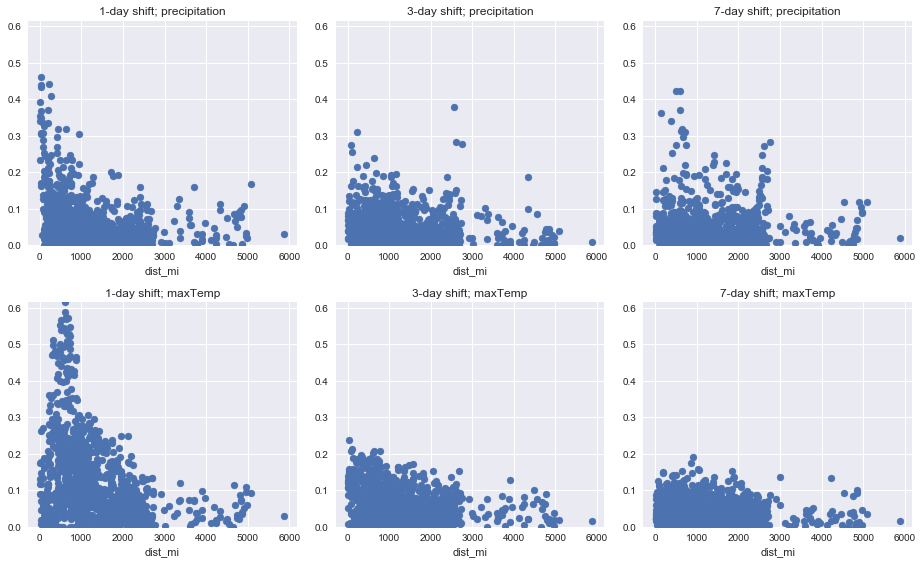

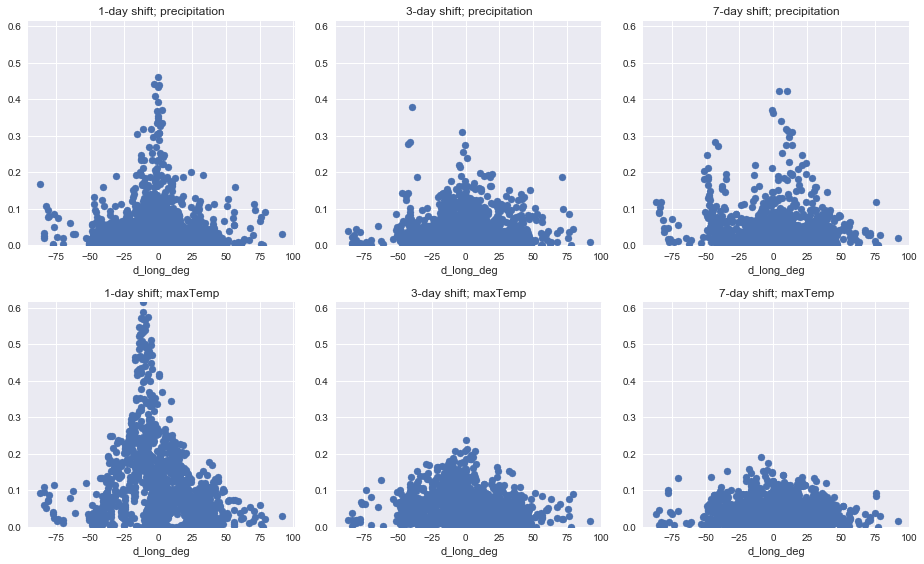

In [23]:
# plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set()

# Variables we're looking at
var_strs = ["precipitation","precipitation","precipitation","maxTemp", "maxTemp", "maxTemp"]
shifts = [1, 3, 7, 1, 3, 7]
coords = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
xvars = ['dist_mi', 'd_long_deg']

# Plots
for xvar in xvars:
    fig, ax = plt.subplots(2,3,figsize=(13,8))
    for j in range(len(coords)):
        this_df = df.loc[(df['shift'] == shifts[j]) & (df['variable'] == var_strs[j])]
        ax[coords[j]].scatter(this_df[f'{xvar}'], this_df['corrStrength'])
        ax[coords[j]].set_title(f'{shifts[j]}-day shift; {var_strs[j]}')
        ax[coords[j]].set(xlabel=f'{xvar}', ylim=(0,max(df['corrStrength'])))

    plt.tight_layout()
    plt.show()

In [24]:
# Close the database
connection.commit()
connection.close()